# Time series analysis

In [3]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [4]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

A **time series** is a sequence of measurements from a system that varies in time.
One famous example is the "hockey stick graph" that shows global average temperature over time (see <https://en.wikipedia.org/wiki/Hockey_stick_graph>).

The example I work with in this chapter comes from Zachary M. Jones, a researcher in political science who studies the black market for cannabis in the U.S. (<http://zmjones.com/marijuana>).
He collected data from a web site called "Price of Weed" that crowdsources market information by asking participants to report the price, quantity, quality, and location of cannabis transactions (<http://www.priceofweed.com/>).
The goal of his project is to investigate the effect of policy decisions, like legalization, on markets.
I find this project appealing because it is an example that uses data to address important political questions, like drug policy.

I hope you will find this chapter interesting, but I'll take this opportunity to reiterate the importance of maintaining a professional attitude to data analysis.
Whether and which drugs should be illegal are important and difficult public policy questions; our decisions should be informed by accurate data reported honestly.

## The Dow Jones

The [MeasuringWorth Foundation](https://www.measuringworth.com/datasets/DJA) has compiled the value of the Dow Jones Industrial Average at the end of each day from February 16, 1885 to the present, with adjustments at several points to make the values comparable.
The series I collected starts on February 16, 1885 and ends on August 30, 2024.
The following cells download and read the data.

In [6]:
# "Citation: Samuel H. Williamson, 'Daily Closing Value of the Dow Jones Average, 1885 to Present,'
# MeasuringWorth, 2022. "

# Downloaded from https://www.measuringworth.com/datasets/DJA, September 3, 2024

<IPython.core.display.Javascript object>

In [7]:
DATA_PATH = "https://github.com/AllenDowney/ThinkStats/raw/v3/data/"
filename = "DJA.csv"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [9]:
djia = pd.read_csv(filename, skiprows=4, parse_dates=[0], index_col=0)
djia.head()

,DJIA
Date,
1885-02-16,30.9226
1885-02-17,31.3365
1885-02-18,31.4744
1885-02-19,31.6765
1885-02-20,31.4252


<IPython.core.display.Javascript object>

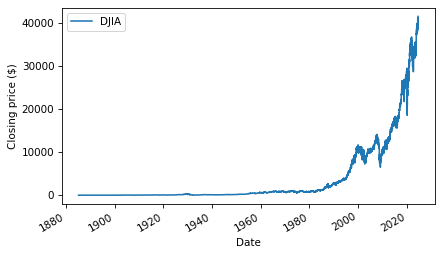

<IPython.core.display.Javascript object>

In [11]:
djia["DJIA"].plot()

decorate(ylabel="Closing price ($)")

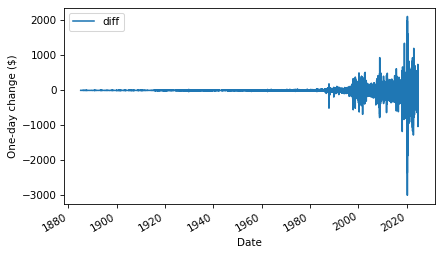

<IPython.core.display.Javascript object>

In [18]:
djia["diff"] = djia["DJIA"].diff()
djia["diff"].plot()

decorate(ylabel="One-day change ($)")

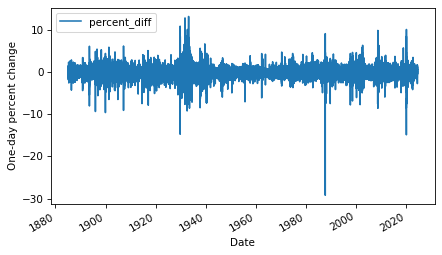

<IPython.core.display.Javascript object>

In [20]:
djia["percent_diff"] = djia["diff"] / djia["DJIA"] * 100
djia["percent_diff"].plot()

decorate(ylabel="One-day percent change")

<Axes: xlabel='percent_diff'>

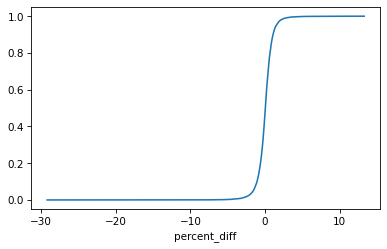

<IPython.core.display.Javascript object>

In [24]:
from empiricaldist import Cdf

cdf_percent_diff = Cdf.from_seq(djia["percent_diff"])
cdf_percent_diff.plot()

In [25]:
up_day = djia.query("percent_diff > 0")
down_day = djia.query("percent_diff < 0")

<IPython.core.display.Javascript object>

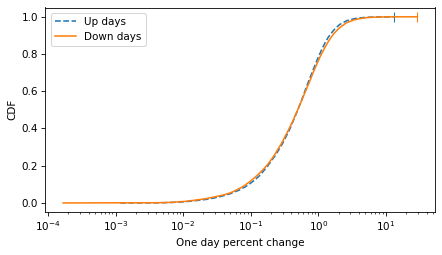

<IPython.core.display.Javascript object>

In [38]:
cdf_up = Cdf.from_seq(up_day["percent_diff"])
cdf_up.plot(label="Up days", ls="--")
plt.plot(cdf_up.qs.max(), 1, "|", color="C0", ms=10)

cdf_down = Cdf.from_seq(-down_day["percent_diff"])
cdf_down.plot(label="Down days")
plt.plot(cdf_down.qs.max(), 1, "|", color="C1", ms=10)

decorate(xlabel="One day percent change", xscale="log", ylabel="CDF")

In [64]:
recent = djia.query('index > "1936-01-01"')

<IPython.core.display.Javascript object>

<Axes: xlabel='Date'>

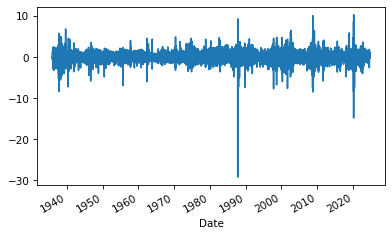

<IPython.core.display.Javascript object>

In [65]:
recent["percent_diff"].plot()

In [81]:
annual = djia.groupby(djia.index.year).last().drop(2024)
annual["diff"] = annual["DJIA"].diff()
annual["percent_diff"] = annual["diff"] / annual["DJIA"].shift(1) * 100
annual

,DJIA,diff,percent_diff
Date,,,
1885,39.4859,NaN,NaN
1886,41.2391,1.7532,4.440066
1887,37.7693,-3.4698,-8.413860
1888,39.5866,1.8173,4.811580
1889,42.0394,2.4528,6.196036
...,...,...,...
2019,28538.4400,5210.9800,22.338394
2020,30606.4800,2068.0400,7.246507
2021,36338.3000,5731.8200,18.727472


<IPython.core.display.Javascript object>

<Axes: xlabel='Date'>

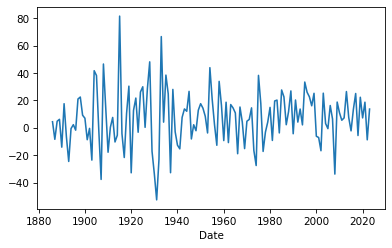

<IPython.core.display.Javascript object>

In [82]:
annual["percent_diff"].plot()

In [88]:
annual["year"] = annual.index
interval = annual.loc[1972:]

<IPython.core.display.Javascript object>

In [89]:
import statsmodels.formula.api as smf

model = smf.ols('percent_diff ~ year', data=interval).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           percent_diff   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1330
Date:                Thu, 05 Sep 2024   Prob (F-statistic):              0.717
Time:                        16:13:23   Log-Likelihood:                -216.00
No. Observations:                  52   AIC:                             436.0
Df Residuals:                      50   BIC:                             439.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -97.0885    290.012     -0.335      0.739    -679.595     485.418
year           0.0529      0.145      0.365      0.717      -0.239       0.345
==============================================================================
Omnibus:                        2.848   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.399
Skew:                          -0.526   Prob(JB):                        0.301
Kurtosis:                       2.968   Cond. No.                     2.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [90]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'annual' dataframe has 'percent_diff' column for percentage changes
# Step 1: Define the ARIMA model on the percent differences
model = ARIMA(annual['percent_diff'], order=(1, 1, 1))

# Step 2: Fit the model
model_fit = model.fit()

# Step 3: Display the summary
print(model_fit.summary())

# Step 4: Forecast future percent differences
forecast_steps = 10  # Forecast the next 10 periods
forecast = model_fit.forecast(steps=forecast_steps)
print(forecast)


                               SARIMAX Results                                
Dep. Variable:           percent_diff   No. Observations:                  139
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -616.672
Date:                Thu, 05 Sep 2024   AIC                           1239.344
Time:                        16:15:41   BIC                           1248.125
Sample:                             0   HQIC                          1242.912
                                - 139                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0386      0.075     -0.512      0.609      -0.186       0.109
ma.L1         -0.9996      1.401     -0.714      0.475      -3.745       1.746
sigma2       409.2568    574.580      0.712      0.4

/home/downey/miniconda3/envs/ThinkStats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/downey/miniconda3/envs/ThinkStats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/downey/miniconda3/envs/ThinkStats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/downey/miniconda3/envs/ThinkStats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/downey/miniconda3/envs/ThinkStats/lib/

<IPython.core.display.Javascript object>

Exercise: Check if volatility has increased by running a regression of absolute value of percent change over time

Filling missing dates

In [22]:
def fill_series(series):
    index = series.index
    full_date_range = pd.date_range(start=index.min(), end=index.max(), freq="D")
    return series.reindex(full_date_range).ffill()

<IPython.core.display.Javascript object>

In [24]:
fill_series(djia["DJIA"])

2024-08-19    40896.53
2024-08-20    40834.97
2024-08-21    40890.49
2024-08-22    40712.78
2024-08-23    41175.08
2024-08-24    41175.08
2024-08-25    41175.08
2024-08-26    41240.52
2024-08-27    41250.50
2024-08-28    41091.42
2024-08-29    41335.05
2024-08-30    41563.08
Freq: D, Name: DJIA, dtype: float64

<IPython.core.display.Javascript object>

## Importing and cleaning

The data I downloaded from Mr. Jones's site is in the repository for this book.
The following code reads it into a Pandas `DataFrame`:

In [4]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/mj-clean.csv")

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd

transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


<IPython.core.display.Javascript object>

`parse_dates` tells `read_csv` to interpret values in column 5 as dates and convert them to NumPy `datetime64` objects.

The `DataFrame` has a row for each reported transaction and the following columns:

-   city: string city name.

-   state: two-letter state abbreviation.

-   price: price paid in dollars.

-   amount: quantity purchased in grams.

-   quality: high, medium, or low quality, as reported by the purchaser.

-   date: date of report, presumed to be shortly after date of purchase.

-   ppg: price per gram, in dollars.

-   state.name: string state name.

-   lat: approximate latitude of the transaction, based on city name.

-   lon: approximate longitude of the transaction.

Each transaction is an event in time, so we could treat this dataset as a time series.
But the events are not equally spaced in time; the number of transactions reported each day varies from 0 to several hundred.
Many methods used to analyze time series require the measurements to be equally spaced, or at least things are simpler if they are.

In order to demonstrate these methods, I divide the dataset into groups by reported quality, and then transform each group into an equally spaced series by computing the mean daily price per gram.

In [6]:
def group_by_quality_and_day(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions

    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby("quality")
    dailies = {}
    for name, group in groups:
        dailies[name] = group_by_day(group)
    return dailies

<IPython.core.display.Javascript object>

`groupby` is a `DataFrame` method that returns a GroupBy object, `groups`; used in a for loop, it iterates the names of the groups and the `DataFrame`s that represent them.
Since the values of `quality` are `low`, `medium`, and `high`, we get three groups with those names.

The loop iterates through the groups and calls `GroupByDay`, which computes the daily average price and returns a new `DataFrame`:

In [7]:
def group_by_day(transactions, func="mean"):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[["date", "ppg"]].groupby("date")
    daily = grouped.aggregate(func)
    daily["date"] = daily.index
    start = daily.date.iloc[0]
    one_year = np.timedelta64(52, "W")
    daily["years"] = (daily.date - start) / one_year
    return daily

<IPython.core.display.Javascript object>

The parameter, `transactions`, is a `DataFrame` that contains columns `date` and `ppg`.
We select these two columns, then group by `date`.

The result, `grouped`, is a map from each date to a `DataFrame` that contains prices reported on that date.
`aggregate` is a GroupBy method that iterates through the groups and applies a function to each column of the group; in this case there is only one column, `ppg`.
So the result of `aggregate` is a `DataFrame` with one row for each date and one column, `ppg`.

Dates in these `DataFrame`s are stored as NumPy `datetime64` objects, which are represented as 64-bit integers in nanoseconds.
For some of the analyses coming up, it will be convenient to work with time in more human-friendly units, like years.
So `GroupByDay` adds a column named `date` by copying the `index`, then adds `years`, which contains the number of years since the first transaction as a floating-point number.

The resulting `DataFrame` has columns `ppg`, `date`, and `years`.

In [8]:
dailies = group_by_quality_and_day(transactions)

<IPython.core.display.Javascript object>

## Plotting

The result from `GroupByQualityAndDay` is a map from each quality to a `DataFrame` of daily prices.
Here's the code I use to plot the three time series:

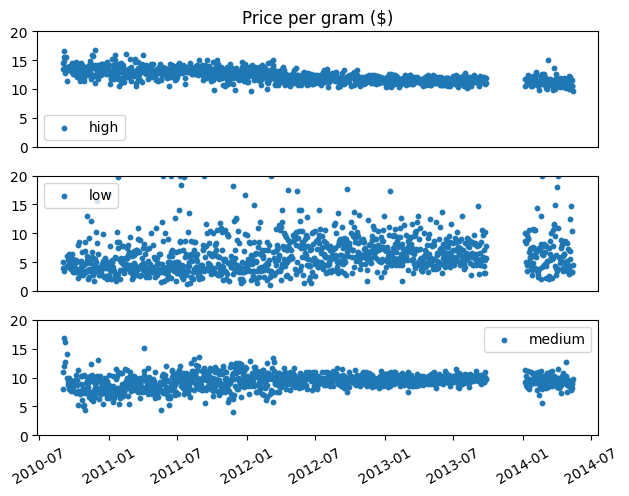

<IPython.core.display.Javascript object>

In [9]:
import matplotlib.pyplot as plt

for i, (name, daily) in enumerate(dailies.items()):
    plt.subplot(3, 1, i + 1)
    title = "Price per gram ($)" if i == 0 else ""
    plt.scatter(daily.index, daily.ppg, s=10, label=name)
    decorate(ylim=[0, 20], title=title)

    if i == 2:
        plt.xticks(rotation=30)
    else:
        plt.xticks([])

The loop iterates through the `DataFrame`s and creates a scatter plot for each.
It is common to plot time series with line segments between the points, but in this case there are many data points and prices are highly variable, so adding lines would not help.

Since the labels on the x-axis are dates, I use `plt.xticks` to rotate the "ticks" 30 degrees, making them more readable.

One apparent feature in these plots is a gap around November 2013.
It's possible that data collection was not active during this time, or the data might not be available.
We will consider ways to deal with this missing data later.

Visually, it looks like the price of high quality cannabis is declining during this period, and the price of medium quality is increasing.
The price of low quality might also be increasing, but it is harder to tell, since it seems to be more volatile.
Keep in mind that quality data is reported by volunteers, so trends over time might reflect changes in how participants apply these labels.

## Linear regression

Although there are methods specific to time series analysis, for many problems a simple way to get started is by applying general-purpose tools like linear regression.
The following function takes a `DataFrame` of daily prices and computes a least squares fit, returning the model and results objects from StatsModels:

In [10]:
import statsmodels.formula.api as smf


def run_linear_model(daily):
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

<IPython.core.display.Javascript object>

Then we can iterate through the qualities and fit a model to each:

In [11]:
from thinkstats import summarize_results

for name, daily in dailies.items():
    model, results = run_linear_model(daily)
    print(name)
    summarize_results(results)
    print()

high
Intercept   13.4   (0)
years   -0.706   (3.69e-160)
R^2 0.4441
Std(ys) 1.096
Std(res) 0.8174

low
Intercept   5.36   (3.15e-130)
years   0.566   (2.76e-09)
R^2 0.0296
Std(ys) 3.381
Std(res) 3.332

medium
Intercept   8.88   (0)
years   0.282   (1.82e-15)
R^2 0.0499
Std(ys) 1.304
Std(res) 1.272



<IPython.core.display.Javascript object>

The estimated slopes indicate that the price of high quality cannabis dropped by about 71 cents per year during the observed interval; for medium quality it increased by 28 cents per year, and for low quality it increased by 57 cents per year.
These estimates are all statistically significant with very small p-values.

The $R^2$ value for high quality cannabis is 0.44, which means that time as an explanatory variable accounts for 44% of the observed variability in price.
For the other qualities, the change in price is smaller, and variability in prices is higher, so the values of $R^2$ are smaller (but still statistically significant).

The following code plots the observed prices and the fitted values:

In [12]:
def plot_fitted_values(model, results, label=""):
    years = model.exog[:, 1]
    values = model.endog
    plt.scatter(years, values, s=15, label=label)
    plt.plot(years, results.fittedvalues, color="C1", label="model")
    decorate()

<IPython.core.display.Javascript object>

From `model`, `plot_fitted_values` gets `exog` and `endog` , NumPy arrays with the exogenous (explanatory) and endogenous (dependent) variables.
Then it makes a scatter plot of the data points and a line plot of the fitted values.

The following figure shows the results for high quality cannabis.

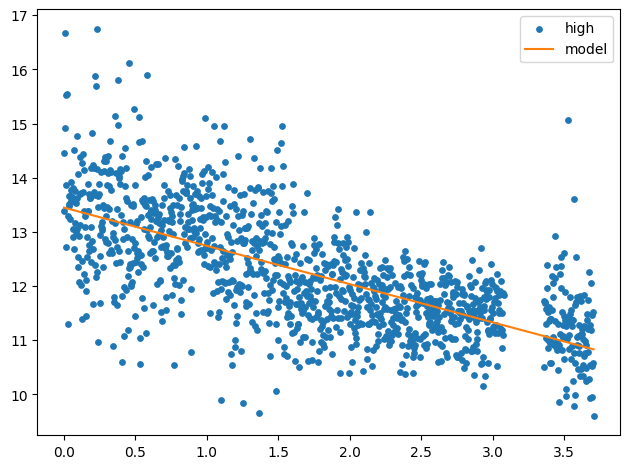

<IPython.core.display.Javascript object>

In [13]:
model, results = run_linear_model(dailies["high"])
plot_fitted_values(model, results, label="high")

The model seems like a good linear fit for the data; nevertheless, linear regression is not the most appropriate choice for this data:

-   First, there is no reason to expect the long-term trend to be a line or any other simple function.
In general, prices are determined by supply and demand, both of which vary over time in unpredictable ways.

-   Second, the linear regression model gives equal weight to all data, recent and past.
For purposes of prediction, we should probably give more weight to recent data.

-   Finally, one of the assumptions of linear regression is that the residuals are uncorrelated noise.
With time series data, this assumption is often false because successive values are correlated.

The next section presents an alternative that is more appropriate for time series data.

## Moving averages

Most time series analysis is based on the modeling assumption that the observed series is the sum of three components:

-   Trend: A smooth function that captures persistent changes.

-   Seasonality: Periodic variation, possibly including daily, weekly, monthly, or yearly cycles.

-   Noise: Random variation around the long-term trend.

Regression is one way to extract the trend from a series, as we saw in the previous section.
But if the trend is not a simple function, a good alternative is a **moving average**.
A moving average divides the series into overlapping regions, called **windows**, and computes the average of the values in each window.

One of the simplest moving averages is the **rolling mean**, which computes the mean of the values in each window.
For example, if the window size is 3, the rolling mean computes the mean of values 0 through 2, 1 through 3, 2 through 4, etc.

Pandas provides `rolling_mean`, which takes a `Series` and a window size and returns a new `Series`.

In [14]:
array = np.arange(10)

<IPython.core.display.Javascript object>

In [15]:
series = pd.Series(array)
series.rolling(3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

<IPython.core.display.Javascript object>

The first two values are `nan`; the next value is the mean of the first three elements, 0, 1, and 2. The next value is the mean of 1, 2, and 3. And so on.

Before we can apply `rolling_mean` to the cannabis data, we have to deal with missing values.
There are a few days in the observed interval with no reported transactions for one or more quality categories, and a period in 2013 when data collection was not active.

In the `DataFrame`s we have used so far, these dates are absent; the index skips days with no data.
For the analysis that follows, we need to represent this missing data explicitly.
We can do that by "reindexing" the `DataFrame`:

In [16]:
dates = pd.date_range(daily.index.min(), daily.index.max())
reindexed = daily.reindex(dates)

<IPython.core.display.Javascript object>

The first line computes a date range that includes every day from the beginning to the end of the observed interval.
The second line creates a new `DataFrame` with all of the data from `daily`, but including rows for all dates, filled with `nan`.

Now we can plot the rolling mean like this:

In [17]:
from thinkstats import underride


def scatter_series(xs, **options):
    """Makes a scatter plot from a Series.

    xs: Series
    options: options passed to scatter
    """
    options = underride(options, color="blue", alpha=0.2, s=30, edgecolors="none")
    ys = xs.values
    xs = xs.index
    plt.scatter(xs, ys, **options)

<IPython.core.display.Javascript object>

In [18]:
def plot_rolling_mean(daily, label):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    scatter_series(reindexed.ppg, s=15, alpha=0.2, label=label)
    roll_mean = pd.Series(reindexed.ppg).rolling(30).mean()
    plt.plot(roll_mean, label="rolling mean", color="#ff7f00")
    plt.xticks(rotation=30)
    decorate(ylabel="price per gram ($)")

<IPython.core.display.Javascript object>

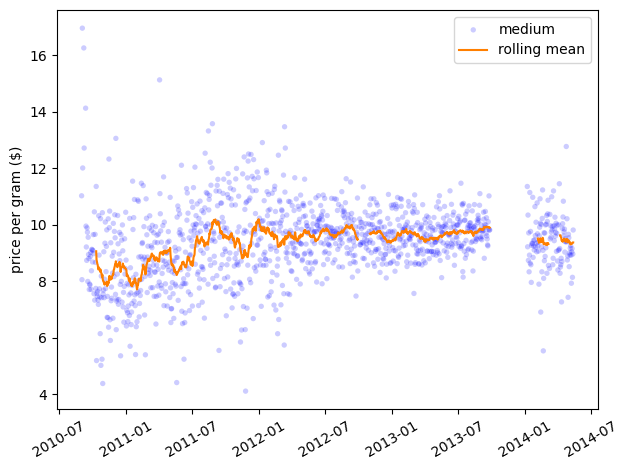

<IPython.core.display.Javascript object>

In [19]:
plot_rolling_mean(daily, name)

The window size is 30, so each value in `roll_mean` is the mean of 30 values from `reindexed.ppg`.
The rolling mean seems to do a good job of smoothing out the noise and extracting the trend.
The first 29 values are `nan`, and wherever there's a missing value, it's followed by another 29 `nan`s.
There are ways to fill in these gaps, but they are a minor nuisance.

An alternative is the **exponentially-weighted moving average** (EWMA), which has two advantages.
First, as the name suggests, it computes a weighted average where the most recent value has the highest weight and the weights for previous values drop off exponentially.
Second, the Pandas implementation of EWMA handles missing values better.

In [20]:
def plot_ewma(daily, label):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    scatter_series(reindexed.ppg, s=15, alpha=0.2, label=label)
    roll_mean = reindexed.ppg.ewm(30).mean()
    plt.plot(roll_mean, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    decorate(ylabel="price per gram ($)")

<IPython.core.display.Javascript object>

The **span** parameter corresponds roughly to the window size of a moving average; it controls how fast the weights drop off, so it determines the number of points that make a non-negligible contribution to each average.

The following figure shows the EWMA for the same data.


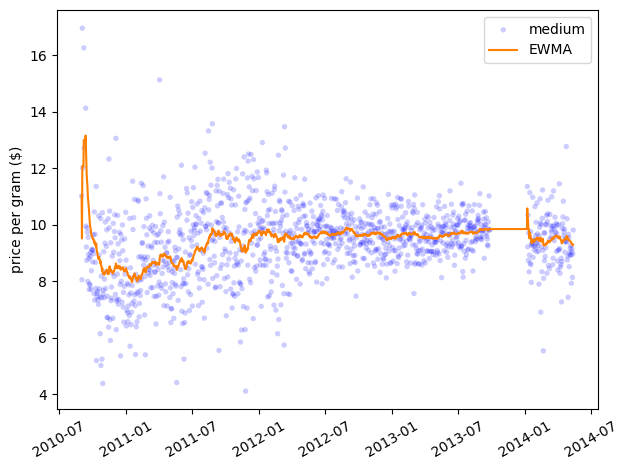

<IPython.core.display.Javascript object>

In [21]:
plot_ewma(daily, name)

It is similar to the rolling mean, where they are both defined, but it has no missing values, which makes it easier to work with.
The values are noisy at the beginning of the time series, because they are based on fewer data points.

## Missing values

Now that we have characterized the trend of the time series, the next step is to investigate seasonality, which is periodic behavior.
Time series data based on human behavior often exhibits daily, weekly, monthly, or yearly cycles.
In the next section I present methods to test for seasonality, but they don't work well with missing data, so we have to solve that problem first.

A simple and common way to fill missing data is to use a moving average.
The `Series` method `fillna` does just what we want:

In [22]:
from thinkstats import resample


def fill_missing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    ewma = pd.Series(reindexed.ppg).ewm(span=span).mean()
    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + resample(resid, len(reindexed))
    reindexed["ppg"] = reindexed.ppg.fillna(fake_data)
    reindexed["ewma"] = ewma
    reindexed["resid"] = reindexed.ppg - ewma
    return reindexed

<IPython.core.display.Javascript object>

In [23]:
def plot_filled(daily, label):
    """Plots the EWMA and filled data.

    daily: DataFrame of daily prices
    """
    filled = fill_missing(daily, span=30)
    scatter_series(filled.ppg, s=15, alpha=0.2, label=label)
    plt.plot(filled.ewma, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    decorate(ylabel="Price per gram ($)")

<IPython.core.display.Javascript object>

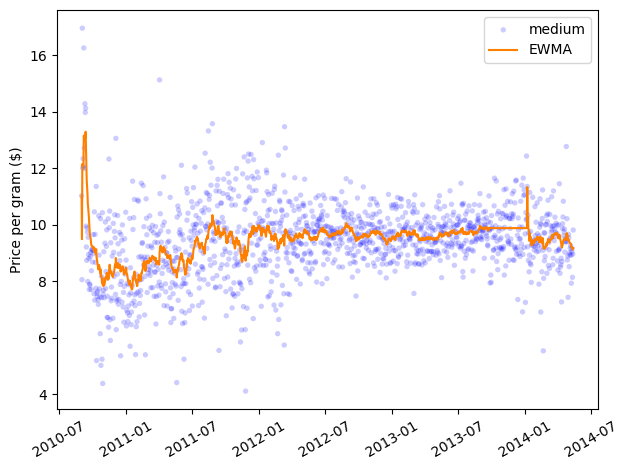

<IPython.core.display.Javascript object>

In [24]:
plot_filled(daily, name)

# TODO, what's up with that blip near the end?

Wherever `reindexed.ppg` is `nan`, `fillna` replaces it with the corresponding value from `ewma`.

A drawback of this method is that it understates the noise in the series.
We can solve that problem by adding in resampled residuals:

In [25]:
dates = pd.date_range(daily.index.min(), daily.index.max())
reindexed = daily.reindex(dates)
ewma = pd.Series(reindexed.ppg).ewm(span=30).mean()

<IPython.core.display.Javascript object>

In [26]:
resid = (reindexed.ppg - ewma).dropna()
fake_data = ewma + resample(resid, len(reindexed))
reindexed["ppg"] = reindexed.ppg.fillna(ewma)

<IPython.core.display.Javascript object>

`resid` contains the residual values, not including days when `ppg` is `nan`.
`fake_data` contains the sum of the moving average and a random sample of residuals.
Finally, `fillna` replaces `nan` with values from `fake_data`.

In [27]:
# TODO: missing figure in the sequence here?

<IPython.core.display.Javascript object>

The filled data is visually similar to the actual values.
Since the resampled residuals are random, the results are different every time; later we'll see how to characterize the error created by missing values.

## Serial correlation

As prices vary from day to day, you might expect to see patterns.
If the price is high on Monday, you might expect it to be high for a few more days; and if it's low, you might expect it to stay low.
A pattern like this is called **serial correlation**, because each value is correlated with the next one in the series.

To compute serial correlation, we can shift the time series by an interval called a **lag**, and then compute the correlation of the shifted series with the original:

In [28]:
from thinkstats import corr


def serial_corr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    return corr(xs, ys)

<IPython.core.display.Javascript object>

After the shift, the first `lag` values are `nan`, so I use a slice to remove them before computing `Corr`.

If we apply `SerialCorr` to the raw price data with lag 1, we find serial correlation 0.48 for the high quality category, 0.16 for medium and 0.10 for low.
In any time series with a long-term trend, we expect to see strong serial correlations; for example, if prices are falling, we expect to see values above the mean in the first half of the series and values below the mean in the second half.

It is more interesting to see if the correlation persists if you subtract away the trend.
For example, we can compute the residual of the EWMA and then compute its serial correlation:

In [29]:
filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = fill_missing(daily, span=30)

<IPython.core.display.Javascript object>

In [30]:
for name, filled in filled_dailies.items():
    r = serial_corr(filled.ppg, lag=1)
    print(name, r)

high 0.4869645585016254
low 0.11730067146829114
medium 0.18876645108422843


<IPython.core.display.Javascript object>

With lag=1, the serial correlations for the de-trended data are -0.022 for high quality, -0.015 for medium, and 0.036 for low.
These values are small, indicating that there is little or no one-day serial correlation in this series.

To check for weekly, monthly, and yearly seasonality, I ran the analysis again with different lags.
Here are the results:

In [31]:
for name, filled in filled_dailies.items():
    r = serial_corr(filled.resid, lag=1)
    print(name, r)

high -0.004114986228242842
low 0.045461650184415815
medium -0.010294571597965742


<IPython.core.display.Javascript object>

In the next section we'll test whether these correlations are statistically significant (they are not), but at this point we can tentatively conclude that there are no substantial seasonal patterns in these series, at least not with these lags.

## Autocorrelation

If you think a series might have some serial correlation, but you don't know which lags to test, you can test them all! The **autocorrelation function** is a function that maps from lag to the serial correlation with the given lag.
"Autocorrelation" is another name for serial correlation, used more often when the lag is not 1.

StatsModels provides functions for time series analysis, including `acf`, which computes the autocorrelation function:

In [32]:
import statsmodels.tsa.stattools as smtsa

filled = filled_dailies["high"]
acf = smtsa.acf(filled.resid, nlags=365, adjusted=True, fft=False)

<IPython.core.display.Javascript object>

`acf` computes serial correlations with lags from 0 through `nlags`.
The `unbiased` flag tells `acf` to correct the estimates for the sample size.
The result is an array of correlations.
If we select daily prices for high quality, and extract correlations for lags 1, 7, 30, and 365, we can confirm that `acf` and `SerialCorr` yield approximately the same results:

In [33]:
f"{acf[0]:.2} {acf[1]:.2} {acf[7]:.2} {acf[30]:.2} {acf[365]:.2}"

'1.0 -0.0041 0.011 -0.0042 0.055'

<IPython.core.display.Javascript object>

With `lag=0`, `acf` computes the correlation of the series with itself, which is always 1.


The following figure shows autocorrelation functions for the three quality categories, with `nlags=40`.


In [34]:
def simulate_autocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.

    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    t = []
    for _ in range(iters):
        filled = fill_missing(daily, span=30)
        resid = resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, adjusted=True, fft=False)[1:]
        t.append(np.abs(acf))
    high = percentile_rows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags + 1)
    plt.fill_between(lags, low, high, alpha=0.2, color="gray")

<IPython.core.display.Javascript object>

In [39]:
from thinkstats import percentile_rows


def plot_auto_correlation(dailies, nlags=40, add_weekly=False):
    """Plots autocorrelation functions.

    dailies: map from category name to DataFrame of daily prices
    nlags: number of lags to compute
    add_weekly: boolean, whether to add a simulated weekly pattern
    """
    daily = dailies["high"]
    simulate_autocorrelation(daily)
    for name, daily in dailies.items():
        if add_weekly:
            daily.ppg = add_weekly_seasonality(daily)
        filled = fill_missing(daily, span=30)
        acf = smtsa.acf(filled.resid, nlags=nlags, adjusted=True, fft=False)
        lags = np.arange(len(acf))
        plt.plot(lags[1:], acf[1:], label=name)

<IPython.core.display.Javascript object>

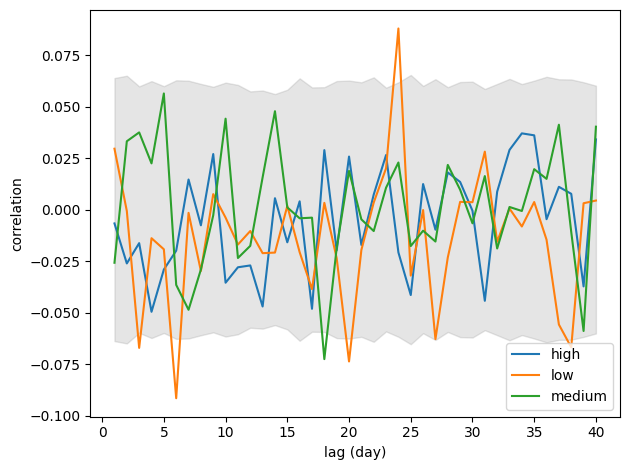

<IPython.core.display.Javascript object>

In [40]:
axis = [0, 41, -0.2, 0.2]
plot_auto_correlation(dailies, add_weekly=False)
decorate(xlabel="lag (day)", ylabel="correlation", loc="lower right")

The gray region shows the normal variability we would expect if there is no actual autocorrelation; anything that falls outside this range is statistically significant, with a p-value less than 5%. Since the false positive rate is 5%, and we are computing 120 correlations (40 lags for each of 3 times series), we expect to see about 6 points outside this region.
In fact, there are 7. We conclude that there are no autocorrelations in these series that could not be explained by chance.

I computed the gray regions by resampling the residuals.
You can see my code in `timeseries.py`; the function is called `SimulateAutocorrelation`.

To see what the autocorrelation function looks like when there is a seasonal component, I generated simulated data by adding a weekly cycle.
Assuming that demand for cannabis is higher on weekends, we might expect the price to be higher.
To simulate this effect, I select dates that fall on Friday or Saturday and add a random amount to the price, chosen from a uniform distribution from \$0 to \$2.

In [41]:
def add_weekly_seasonality(daily):
    """Adds a weekly pattern.

    daily: DataFrame of daily prices

    returns: new DataFrame of daily prices
    """
    fri_or_sat = (daily.index.dayofweek == 4) | (daily.index.dayofweek == 5)
    fake = daily.ppg.copy()
    fake[fri_or_sat] += np.random.uniform(0, 2, fri_or_sat.sum())
    return fake

<IPython.core.display.Javascript object>

`frisat` is a boolean `Series`, `True` if the day of the week is Friday or Saturday.
`fake` is a new `DataFrame`, initially a copy of `daily`, which we modify by adding random values to `ppg`.
`frisat.sum()` is the total number of Fridays and Saturdays, which is the number of random values we have to generate.

The following figure shows autocorrelation functions for prices with this simulated seasonality.


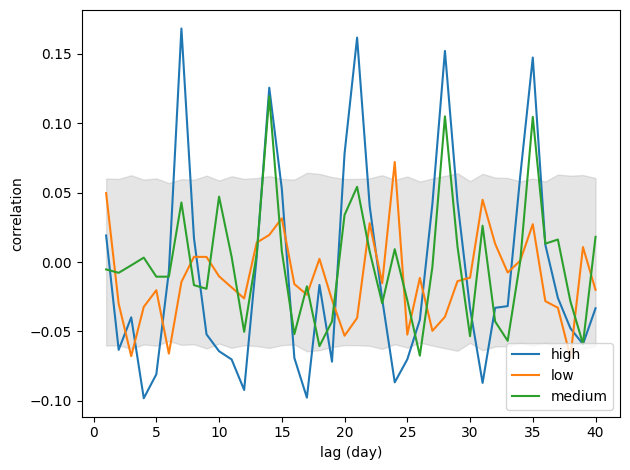

<IPython.core.display.Javascript object>

In [42]:
axis = [0, 41, -0.2, 0.2]
plot_auto_correlation(dailies, add_weekly=True)
decorate(xlabel="lag (day)", ylabel="correlation", loc="lower right")

As expected, the correlations are highest when the lag is a multiple of 7. For high and medium quality, the new correlations are statistically significant.
For low quality they are not, because residuals in this category are large; the effect would have to be bigger to be visible through the noise.

## Prediction

Time series analysis can be used to investigate, and sometimes explain, the behavior of systems that vary in time.
It can also make predictions.

The linear regressions we used in Section [\[timeregress\]](#timeregress){reference-type="ref" reference="timeregress"} can be used for prediction.
The RegressionResults class provides `predict`, which takes a `DataFrame` containing the explanatory variables and returns a sequence of predictions.
Here's the code:

In [43]:
def generate_simple_prediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

<IPython.core.display.Javascript object>

In [44]:
def plot_simple_prediction(name, results, years):
    predict = generate_simple_prediction(results, years)
    plt.scatter(daily.years, daily.ppg, alpha=0.2, label=name)
    plt.plot(years, predict, color="#ff7f00")
    xlim = years[0] - 0.1, years[-1] + 0.1
    decorate(
        title="Predictions",
        xlabel="Years",
        xlim=xlim,
        ylabel="Price per gram ($)",
        loc="upper right",
    )

<IPython.core.display.Javascript object>

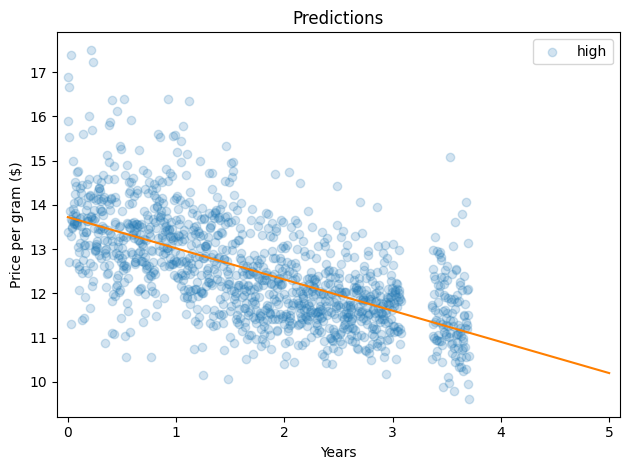

<IPython.core.display.Javascript object>

In [45]:
name = "high"
daily = dailies[name]
_, results = run_linear_model(daily)
years = np.linspace(0, 5, 101)
plot_simple_prediction(name, results, years)

`results` is a RegressionResults object; `years` is the sequence of time values we want predictions for.
The function constructs a `DataFrame`, passes it to `predict`, and returns the result.

If all we want is a single, best-guess prediction, we're done.
But for most purposes it is important to quantify error.
In other words, we want to know how accurate the prediction is likely to be.

There are three sources of error we should take into account:

-   Sampling error: The prediction is based on estimated parameters, which depend on random variation in the sample.
If we run the experiment again, we expect the estimates to vary.

-   Random variation: Even if the estimated parameters are perfect, the observed data varies randomly around the long-term trend, and we expect this variation to continue in the future.

-   Modeling error: We have already seen evidence that the long-term trend is not linear, so predictions based on a linear model will eventually fail.

Another source of error to consider is unexpected future events.
Agricultural prices are affected by weather, and all prices are affected by politics and law.
As I write this, cannabis is legal in two states and legal for medical purposes in 20 more.
If more states legalize it, the price is likely to go down.
But if the federal government cracks down, the price might go up.

Modeling errors and unexpected future events are hard to quantify.
Sampling error and random variation are easier to deal with, so we'll do that first.

To quantify sampling error, I use resampling, as we did in Section [\[regest\]](#regest){reference-type="ref" reference="regest"}.
As always, the goal is to use the actual observations to simulate what would happen if we ran the experiment again.
The simulations are based on the assumption that the estimated parameters are correct, but the random residuals could have been different.
Here is a function that runs the simulations:

In [46]:
def simulate_results(daily, iters=101, func=run_linear_model):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)
    return result_seq

<IPython.core.display.Javascript object>

`daily` is a `DataFrame` containing the observed prices; `iters` is the number of simulations to run.

`SimulateResults` uses `RunLinearModel`, from Section [\[timeregress\]](#timeregress){reference-type="ref" reference="timeregress"}, to estimate the slope and intercept of the observed values.

Each time through the loop, it generates a "fake" dataset by resampling the residuals and adding them to the fitted values.
Then it runs a linear model on the fake data and stores the RegressionResults object.

The next step is to use the simulated results to generate predictions:

In [47]:
def generate_predictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).

    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += resample(fake_results.resid, n)
        predict_seq.append(predict)
    return predict_seq

<IPython.core.display.Javascript object>

`GeneratePredictions` takes the sequence of results from the previous step, as well as `years`, which is a sequence of floats that specifies the interval to generate predictions for, and `add_resid`, which indicates whether it should add resampled residuals to the straight-line prediction.
`GeneratePredictions` iterates through the sequence of RegressionResults and generates a sequence of predictions.


Finally, here's the code that plots a 90% confidence interval for the predictions:

In [48]:
def plot_predictions(daily, years, iters=101, percent=90, func=run_linear_model):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = simulate_results(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p
    predict_seq = generate_predictions(result_seq, years, add_resid=True)
    low, high = percentile_rows(predict_seq, percents)
    plt.fill_between(years, low, high, alpha=0.3, color="gray")

    predict_seq = generate_predictions(result_seq, years, add_resid=False)
    low, high = percentile_rows(predict_seq, percents)
    plt.fill_between(years, low, high, alpha=0.5, color="gray")

<IPython.core.display.Javascript object>

`PlotPredictions` calls `GeneratePredictions` twice: once with `add_resid=True` and again with `add_resid=False`.
It uses `PercentileRows` to select the 5th and 95th percentiles for each year, then plots a gray region between these bounds.

The following figure shows the result.

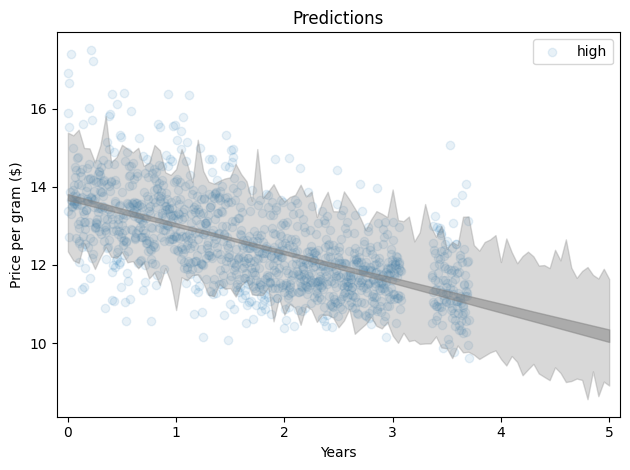

<IPython.core.display.Javascript object>

In [49]:
years = np.linspace(0, 5, 101)
plt.scatter(daily.years, daily.ppg, alpha=0.1, label=name)
plot_predictions(daily, years)
xlim = years[0] - 0.1, years[-1] + 0.1
decorate(title="Predictions", xlabel="Years", xlim=xlim, ylabel="Price per gram ($)")

The dark gray region represents a 90% confidence interval for the sampling error; that is, uncertainty about the estimated slope and intercept due to sampling.

The lighter region shows a 90% confidence interval for prediction error, which is the sum of sampling error and random variation.

These regions quantify sampling error and random variation, but not modeling error.
In general modeling error is hard to quantify, but in this case we can address at least one source of error, unpredictable external events.

The regression model is based on the assumption that the system is **stationary**; that is, that the parameters of the model don't change over time.
Specifically, it assumes that the slope and intercept are constant, as well as the distribution of residuals.

But looking at the moving averages in [which figure?], it seems like the slope changes at least once during the observed interval, and the variance of the residuals seems bigger in the first half than the second.

As a result, the parameters we get depend on the interval we observe.
To see how much effect this has on the predictions, we can extend `simulate_results` to use intervals of observation with different start and end dates.

In [50]:
def simulate_intervals(daily, iters=101, func=run_linear_model):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)
    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()
        for _ in range(iters):
            fake.ppg = results.fittedvalues + resample(results.resid)
            _, fake_results = func(fake)
            result_seq.append(fake_results)
    return result_seq

<IPython.core.display.Javascript object>

In [51]:
def plot_intervals(daily, years, iters=101, percent=90, func=run_linear_model):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = simulate_intervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p
    predict_seq = generate_predictions(result_seq, years, add_resid=True)
    low, high = percentile_rows(predict_seq, percents)
    plt.fill_between(years, low, high, alpha=0.2, color="gray")

<IPython.core.display.Javascript object>

The following figure shows the result for the medium quality category.

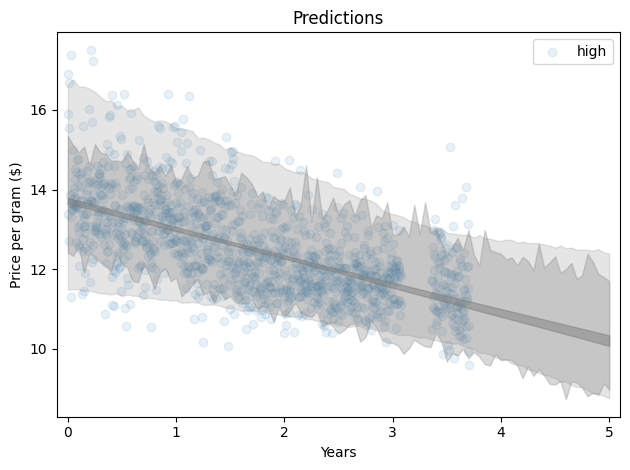

<IPython.core.display.Javascript object>

In [52]:
name = "high"
daily = dailies[name]
plt.scatter(daily.years, daily.ppg, alpha=0.1, label=name)

plot_intervals(daily, years)
plot_predictions(daily, years)
xlim = years[0] - 0.1, years[-1] + 0.1
decorate(title="Predictions", xlabel="Years", xlim=xlim, ylabel="Price per gram ($)")

The lightest gray area shows a confidence interval that includes uncertainty due to sampling error, random variation, and variation in the interval of observation.

The model based on the entire interval has positive slope, indicating that prices were increasing.
But the most recent interval shows signs of decreasing prices, so models based on the most recent data have negative slope.
As a result, the widest predictive interval includes the possibility of decreasing prices over the next year.

## Further reading

Time series analysis is a big topic; this chapter has only scratched the surface.
An important tool for working with time series data is autoregression, which I did not cover here, mostly because it turns out not to be useful for the example data I worked with.

But once you have learned the material in this chapter, you are well prepared to learn about autoregression.
One resource I recommend is Philipp Janert's book, *Data Analysis with Open Source Tools*, O'Reilly Media, 2011.
His chapter on time series analysis picks up where this one leaves off.

## Glossary

-   **time series**: A dataset where each value is associated with a timestamp, often a series of measurements and the times they were collected.

-   **window**: A sequence of consecutive values in a time series, often used to compute a moving average.

-   **moving average**: One of several statistics intended to estimate the underlying trend in a time series by computing averages (of some kind) for a series of overlapping windows.

-   **rolling mean**: A moving average based on the mean value in each window.

-   **exponentially-weighted moving average (EWMA)**: A moving average based on a weighted mean that gives the highest weight to the most recent values, and exponentially decreasing weights to earlier values.

-   **span**: A parameter of EWMA that determines how quickly the weights decrease.

-   **serial correlation**: Correlation between a time series and a shifted or lagged version of itself.

-   **lag**: The size of the shift in a serial correlation or autocorrelation.

-   **autocorrelation**: A more general term for a serial correlation with any amount of lag.

-   **autocorrelation function**: A function that maps from lag to serial correlation.

-   **stationary**: A model is stationary if the parameters and the distribution of residuals does not change over time.

## Exercises

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time.
We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions.
You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [53]:
def run_quadratic_model(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

<IPython.core.display.Javascript object>

In [54]:
name = "high"
daily = dailies[name]
model, results = run_quadratic_model(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     389.6
Date:                Tue, 25 Jun 2024   Prob (F-statistic):          5.79e-132
Time:                        14:31:10   Log-Likelihood:                -1674.7
No. Observations:                1241   AIC:                             3355.
Df Residuals:                    1238   BIC:                             3371.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.9874      0.077    182.140      0.000      13.837      14.138
years         -1.1405      0.096    -11.835      0.000      -1.330      -0.951
years2         0.1201      0.026      4.687      0.000       0.070       0.170
==============================================================================
Omnibus:                       85.242   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.354
Skew:                           0.544   Prob(JB):                     1.34e-28
Kurtosis:                       4.139   Cond. No.                         27.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

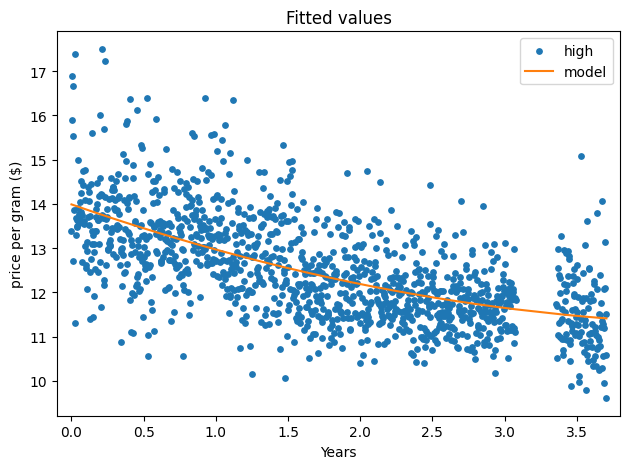

<IPython.core.display.Javascript object>

In [55]:
plot_fitted_values(model, results, label=name)
decorate(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8], ylabel="price per gram ($)"
)

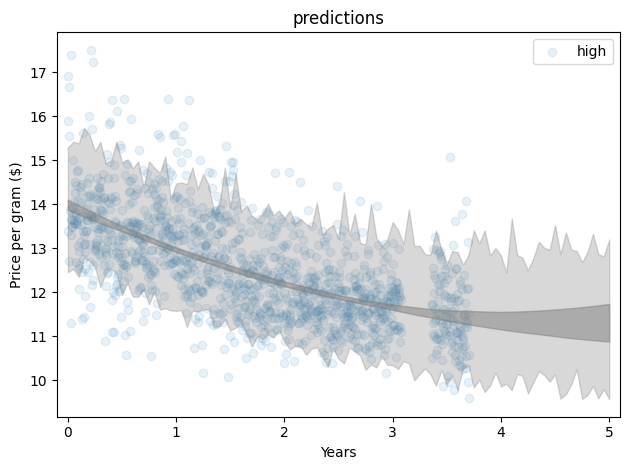

<IPython.core.display.Javascript object>

In [56]:
years = np.linspace(0, 5, 101)
plt.scatter(daily.years, daily.ppg, alpha=0.1, label=name)
plot_predictions(daily, years, func=run_quadratic_model)
decorate(
    title="predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant.
Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [57]:
from thinkstats import HypothesisTest


class SerialCorrelationTest(HypothesisTest):
    """Tests serial correlations by permutation."""

    def test_statistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        series, lag = data
        test_stat = abs(serial_corr(series, lag))
        return test_stat

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

<IPython.core.display.Javascript object>

In [58]:
name = "high"
daily = dailies[name]
series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.p_value()
print(test.actual, pvalue)

0.4246466698622278 0.0


<IPython.core.display.Javascript object>

In [59]:
_, results = run_linear_model(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.p_value()
print(test.actual, pvalue)

0.0802755322515312 0.005


<IPython.core.display.Javascript object>

In [60]:
_, results = run_quadratic_model(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.p_value()
print(test.actual, pvalue)

0.06339927437143862 0.03


<IPython.core.display.Javascript object>

**Bonus Example:** There are several ways to extend the EWMA model to generate predictions.
One of the simplest is something like this:

1. Compute the EWMA of the time series and use the last point as an intercept, `inter`.

2. Compute the EWMA of differences between successive elements in the time series and use the last point as a slope, `slope`.

3. To predict values at future times, compute `inter + slope * dt`, where `dt` is the difference between the time of the prediction and the time of the last observation.


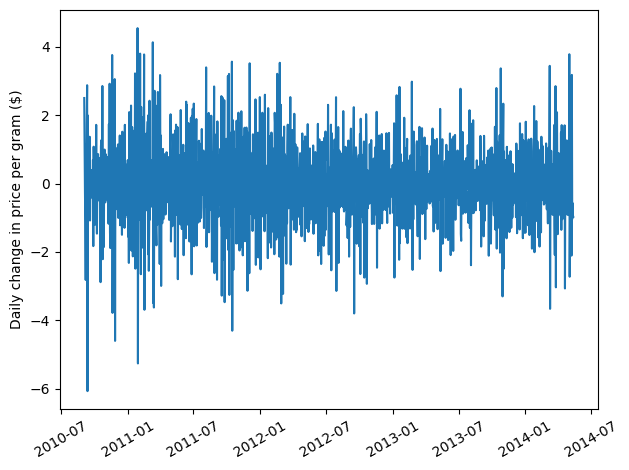

<IPython.core.display.Javascript object>

In [61]:
name = "high"
daily = dailies[name]
filled = fill_missing(daily)
diffs = filled.ppg.diff()
plt.plot(diffs)
plt.xticks(rotation=30)
decorate(ylabel="Daily change in price per gram ($)")

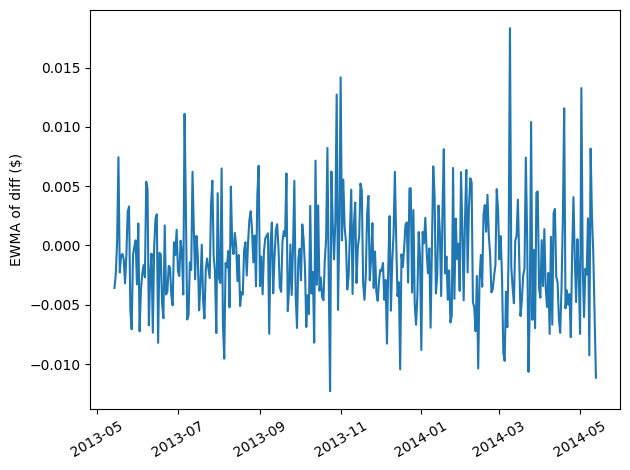

<IPython.core.display.Javascript object>

In [62]:
filled["slope"] = diffs.ewm(span=365).mean()
plt.plot(filled.slope[-365:])
plt.xticks(rotation=30)
decorate(ylabel="EWMA of diff ($)")

In [63]:
start = filled.index[-1]
inter = filled.ewma.iloc[-1]
slope = filled.slope[-30:].mean()
start, inter, slope

(Timestamp('2014-05-13 00:00:00'), 11.308532771389483, -0.0019024650874003618)

<IPython.core.display.Javascript object>

In [64]:
dates = pd.date_range(filled.index.min(), filled.index.max() + np.timedelta64(365, "D"))
predicted = filled.reindex(dates)

<IPython.core.display.Javascript object>

In [65]:
predicted["date"] = predicted.index
one_day = np.timedelta64(1, "D")
predicted["days"] = (predicted.date - start) / one_day
predict = inter + slope * predicted.days
predicted["ewma"] = predicted.ewma.fillna(predict)

<IPython.core.display.Javascript object>

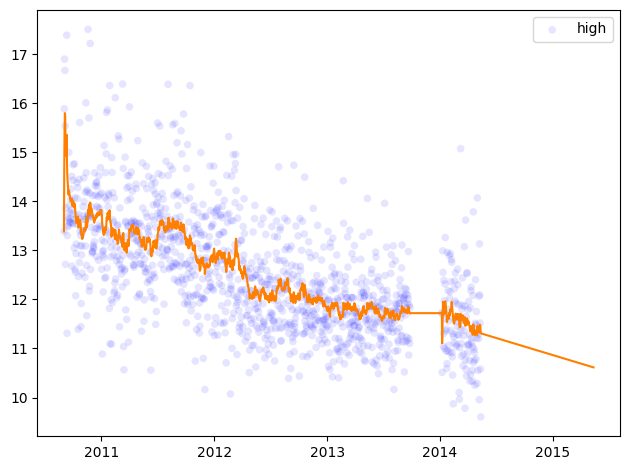

<IPython.core.display.Javascript object>

In [66]:
scatter_series(daily.ppg, alpha=0.1, label=name)
plt.plot(predicted.ewma, color="#ff7f00")
decorate()

As an exercise, run this analysis again for the other quality categories.